## Bir Galaksinin İzofotunu Çıkarmaya Çalışmak

Bu jupyter sayfası bir galaksinin uzakılğını hesaplaya bilmek için izofotunu ölçüp gerekli paralaks dönüşümleriyle uzaklığını hesaplamaya çalışır.

Öncelikle galaksimizi seçelim ben `M88` galaksisini seçiyorum nedenlerim kendime ait (kim bilir belki çalışırken bir albüm dinliyorumdur). Bu galaksinin `Simbad` veri tabanından `DEC(dik açıklık)` ve  `RA(Sağ açıklık)` değerlerini elde edelim (Galaksinin gökyüzünde hangi konumdao olduğunu elde ettik-- burada Equatorial  koordinatlarda çalışıyoruz görüntü nesnesinin `HEADER` bölümünden okursak`COMMENT Coordinates: Equatorial ` bu ifadeyi görebiliriz.) 

In [21]:
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from photutils.isophote import EllipseGeometry, Ellipse
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np


# Simbad'dan M88'in koordinatlarını al
result_table = Simbad.query_object("M88")
ra = result_table["RA"][0]
dec = result_table["DEC"][0]

# Koordinatları belirle
m88_coords = SkyCoord(f"{ra} {dec}", unit=(u.hourangle, u.deg), frame="icrs") # ICRS (International Celestial Reference System)

# SkyView'den veriyi çek (örneğin, DSS survey'inde 5 yay saniyesine yarıçapında bir bölge)
image_list = SkyView.get_images(position=m88_coords, survey='DSS', radius=5*u.arcmin)

data = image_list[0][0].data
header = image_list[0][0].header

In [22]:
header # HEADER - görüntü ile ilgili bilgiler 

SIMPLE  =                    T / Written by SkyView Sun Oct 13 09:44:41 EDT 2024
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =              187.996 / Reference longitude                            
CRVAL2  =              14.4203 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150

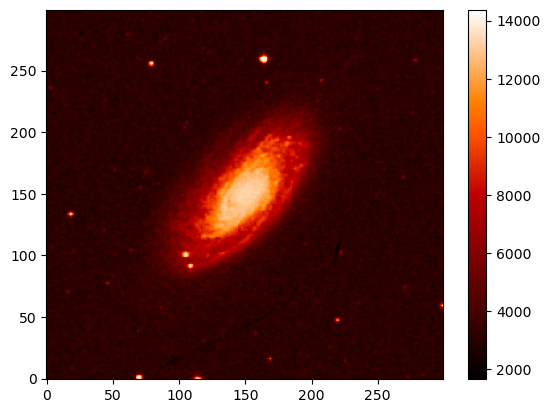

In [23]:
plt.imshow(data, origin='lower', cmap="gist_heat", # neden gist_heat kullandın gece çalıştığınızı düşünerek?
           aspect="auto") # galaksi verising görselleştirelim
plt.colorbar();

Ne kadar güzel değil mi? Aceba galaksiler arası ortamın etkileri çıkarıldı mı? Bu sorunun cevabı için bir önceki hücredeki `HEADER` nesnesinde `A_V` ya da  `EXTINCTION` veya `EXT`

`REDDENING` veya `E(B-V)`: Bu etiket, galaktik sönümleme ile ilişkili kırmızıya çevrilmeyi (reddening) gösterir.
`COMMENT` veya `HISTORY`: Bu etiketlerde, dosyanın oluşturulması veya işlenmesi sırasında galaktik sönümleme hakkında bilgi bulunabilir.

Ben bu belgede böyle bir etiktle karşılaşmadığım için çıkarılmamış kabul ediyor ve sönümmleme katsayısını `dustmaps` adlı bir python kütüphanesi kullanarak hesaplıyorum aşğıdaki kodda `pip install dustmaps` yapıp hata alırsanız diye bir github adresi var local olarak indirip yerleştirmeniz gerekebilir.

In [24]:
from dustmaps.sfd import SFDQuery # https://github.com/guillochon/dustmap/tree/master teşekkürler!

# Sönümleme katsayısını hesaplama
sfd = SFDQuery()
A_V = sfd(m88_coords)

print(f"Sönümleme katsayısı (A_V): {A_V:.3f}")

Sönümleme katsayısı (A_V): 0.038


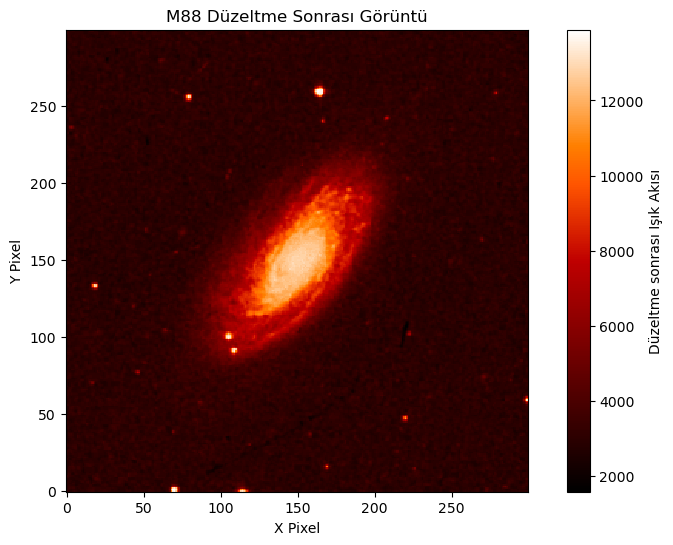

In [25]:
# Orijinal görüntü verisini alın
original_data = image_list[0][0].data

# Sönümleme düzeltmesini uygulayın
extinction_correction = 10**(-0.4 * A_V)

# Düzeltme işlemi
corrected_data = original_data * extinction_correction

# Sonucu görselleştirin
plt.figure(figsize=(10, 6))
plt.imshow(corrected_data, cmap='gist_heat', origin='lower', interpolation='none')
plt.colorbar(label='Düzeltme sonrası Işık Akısı')
plt.title('M88 Düzeltme Sonrası Görüntü')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


In [31]:
c0 = SkyCoord(f"{ra} {dec}", unit=(u.hourangle, u.deg), frame="icrs")
wcs = WCS(header) # WCS (World Coordinate System) sınıfını kullanarak, 
# görüntüdeki piksel koordinatları ile gök koordinatları arasındaki dönüşümü sağlar.
center = wcs.all_world2pix(c0.ra,c0.dec,0) # galaksi merkezini al
size = 600 # görüntü kesitinin boyutunu belirle
cutout = Cutout2D(corrected_data, center, size, wcs=wcs)
# Cutout2D sınıfı, bir görüntüden belirli bir bölgeyi kesip çıkarmak için kullanılır.

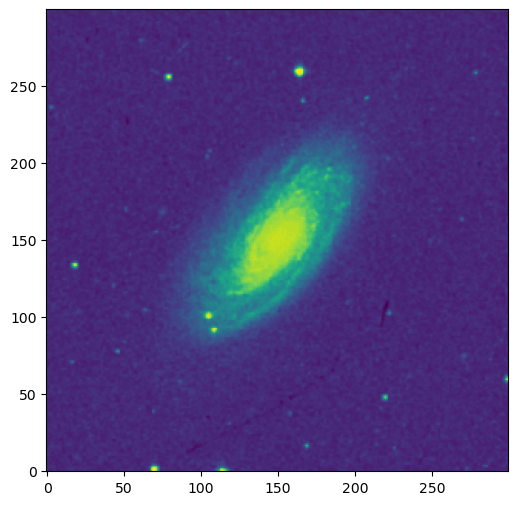

In [7]:
plt.figure(figsize=(10, 6))
plt.imshow(cutout.data, origin="lower") # bölgeyi görselleştir

In [32]:
type(cutout.data)

numpy.ndarray

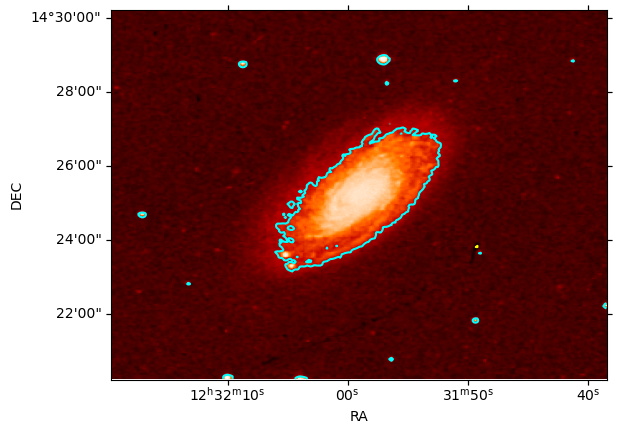

<Figure size 1000x600 with 0 Axes>

In [8]:
ax = plt.subplot(projection=cutout.wcs)

ra = ax.coords[0]
ra.set_major_formatter("hh:mm:ss")

dec = ax.coords[1]
dec.set_major_formatter("dd:mm:ss")

plt.figure(figsize=(10,6))
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
ax.imshow(np.sqrt(cutout.data+1), cmap="gist_heat",
          origin="lower",  aspect = "auto")

a = np.sqrt(cutout.data+1.)
min_a = np.min(a)
max_a = np.max(a)
levels = np.arange(min_a, max_a, (max_a-min_a)/2.)
labels = [item.get_text() for item in
          ax.get_xticklabels()]
ax.contour(a, levels, colors=['yellow','cyan','black'])

[40.55860138 80.23553467]


/home/ebupi/anaconda3/envs/astronomy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ebupi/anaconda3/envs/astronomy/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ebupi/anaconda3/envs/astronomy/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ebupi/anaconda3/envs/astronomy/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ebupi/anaconda3/envs/astronomy/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


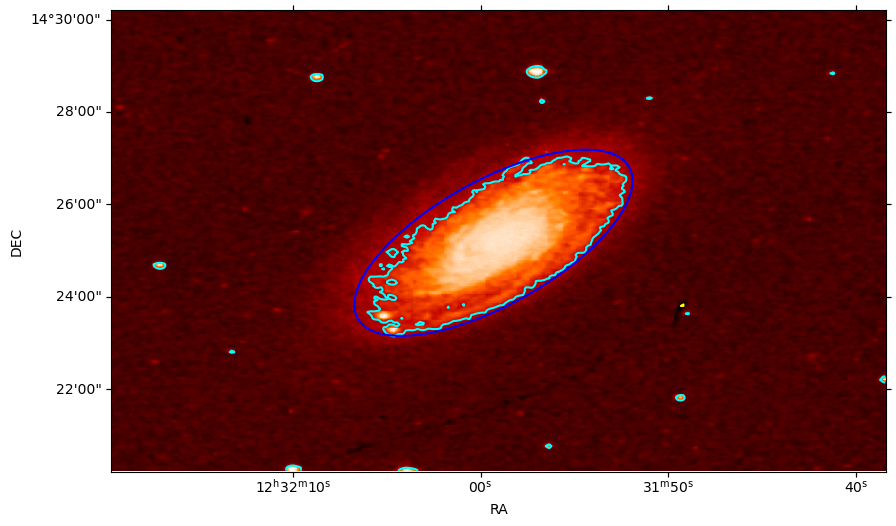

Mavi bölgedeki elipsin yarıçapı: 74.00249944258172 piksel


In [2]:
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from photutils.isophote import EllipseGeometry, Ellipse

# Simbad'dan M88'in koordinatlarını al
result_table = Simbad.query_object("M88")
ra = result_table["RA"][0]
dec = result_table["DEC"][0]

# Koordinatları belirle
m88_coords = SkyCoord(f"{ra} {dec}", unit=(u.hourangle, u.deg))

# SkyView'den veriyi çek (örneğin, DSS survey'inde 5 arcmin yarıçapında bir bölge)
image_list = SkyView.get_images(position=m88_coords, survey='DSS', radius=5*u.arcmin)

# İlk görüntüyü al
data = image_list[0][0].data
header = image_list[0][0].header
wcs = WCS(header)

# Plot ayarları
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=wcs)
ra = ax.coords[0]
ra.set_major_formatter("hh:mm:ss")
dec = ax.coords[1]
dec.set_major_formatter("dd:mm:ss")
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
ax.imshow(np.sqrt(data + 1), cmap="gist_heat", origin="lower", aspect="auto")

# Kontur seviyeleri ve çizgileri
a = np.sqrt(data + 1)
min_a = np.min(a)
max_a = np.max(a)
levels = np.arange(min_a, max_a, (max_a - min_a) / 2)
print(levels)

ax.contour(a, levels, colors=['yellow', 'cyan', 'black'])

# Elips geometrisini belirle ve başlangıç parametrelerini ayarla
geometry = EllipseGeometry(x0=data.shape[1]/2, y0=data.shape[0]/2, sma=10, eps=0.1, pa=45)
ellipse = Ellipse(a, geometry)
isolist = ellipse.fit_image()

 # Mavi bölgeye elips yerleştir ve yarıçapı bul
for iso in isolist:
     if levels[0] < iso.intens < levels[1]:  # Deneme yanılma ile uygun bir seviye seçimi
         x, y = iso.sampled_coordinates()
         ax.plot(x, y, color='blue')
         radius = iso.sma
         break

plt.show()

print(f"Mavi bölgedeki elipsin yarıçapı: {radius} piksel")


[40.55860138 80.23553467]


NameError: name 'radius' is not defined

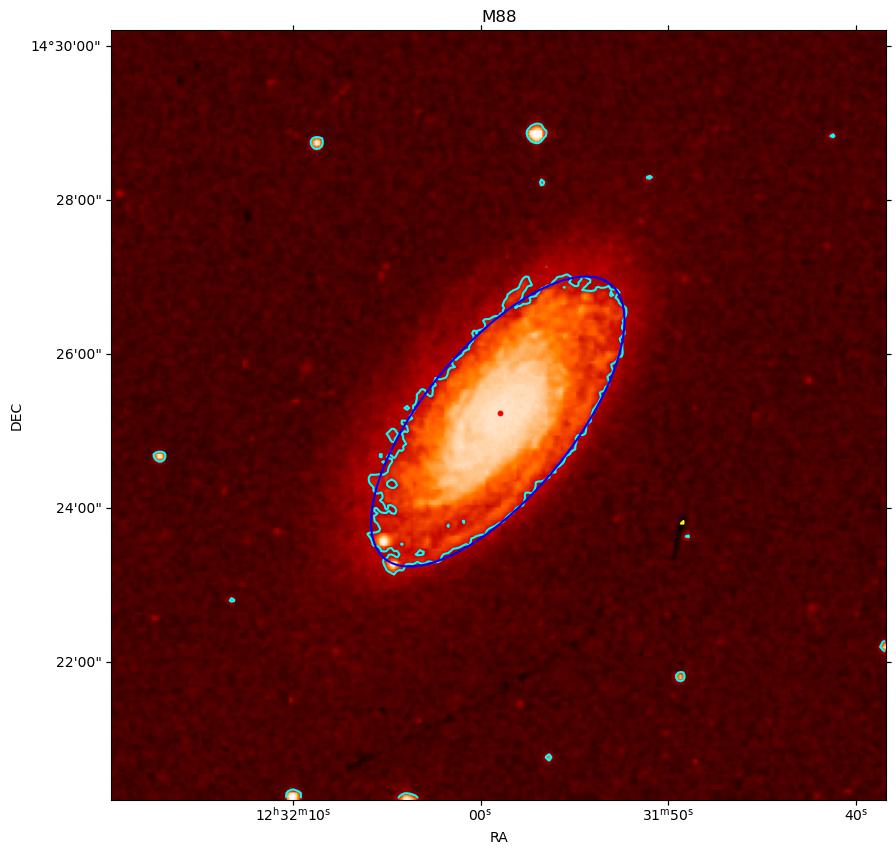

In [13]:
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from photutils.isophote import EllipseGeometry, Ellipse

# Simbad'dan M88'in koordinatlarını al
result_table = Simbad.query_object("M88")
ra = result_table["RA"][0]
dec = result_table["DEC"][0]

# Koordinatları belirle
m88_coords = SkyCoord(f"{ra} {dec}", unit=(u.hourangle, u.deg))

# SkyView'den veriyi çek (örneğin, DSS survey'inde 5 arcmin yarıçapında bir bölge)
image_list = SkyView.get_images(position=m88_coords, survey='DSS', radius=5*u.arcmin)

# İlk görüntüyü al
data = image_list[0][0].data
header = image_list[0][0].header
wcs = WCS(header)

# Plot ayarları
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
ra = ax.coords[0]
ra.set_major_formatter("hh:mm:ss")
dec = ax.coords[1]
dec.set_major_formatter("dd:mm:ss")
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
ax.imshow(np.sqrt(data + 1), cmap="gist_heat", origin="lower", aspect="auto")

# Kontur seviyeleri ve çizgileri
a = np.sqrt(data + 1)
min_a = np.min(a)
max_a = np.max(a)
levels = np.arange(min_a, max_a, (max_a - min_a) / 2)
print(levels)

ax.contour(a, levels, colors=['yellow', 'cyan', 'black'])

# Elips geometrisini belirle ve başlangıç parametrelerini ayarla
geometry = EllipseGeometry(x0=data.shape[1]/2, y0=data.shape[0]/2, sma=20, eps=0.1, pa=45)
ellipse = Ellipse(a, geometry)
isolist = ellipse.fit_image()

# Mavi bölgeye elips yerleştir ve yarıçapı bul
for iso in isolist:
    if levels[0] < iso.intens < levels[1]:
        x, y = iso.sampled_coordinates()
        ax.plot(x, y, color='blue')
        ax.set_title("M88")
        
        # Elipsin merkezini ve yarı-büyük eksen uzunluğunu göster
        ax.scatter(data.shape[1]//2, data.shape[0]//2, color='red', s=10, label='Elips Merkezi')
        #ax.plot([data.shape[1]//2, x[0]], [data.shape[0]//2, y[0]], color='white', label='Yarı-büyük Eksen')
        # 45 derece eğimli yarı-büyük ekseni hesaplayalım ve çizelim
        center_x = data.shape[1] // 2
        center_y = data.shape[0] // 2
        angle = np.deg2rad(50)
        end_x = center_x + radius * np.cos(angle)
        end_y = center_y + radius * np.sin(angle)
        ax.plot([center_x, end_x-1.5], [center_y, end_y-1.5], color='white', label='Yarı-büyük Eksen')
        radius = iso.sma
        break

# Eksenleri, merkez ve yarı-büyük ekseni görselleştirme
ax.legend()
plt.show()

print(f"Mavi bölgedeki elipsin yarıçapı: {radius} piksel")

In [119]:
# Yarı-büyük ekseni yay saniyesine çevirelim
pix_scale = wcs.pixel_scale_matrix[1, 1] * 3600  # Piksel ölçeği yay saniyesi cinsinden
radius_arcsec = radius * pix_scale
print(f"Mavi bölgedeki elipsin yarıçapı: {radius} piksel")
print(f"Yarı-büyük eksen uzunluğu: {radius_arcsec:.2f} yay saniyesi")

Mavi bölgedeki elipsin yarıçapı: 69.04542428786206 piksel
Yarı-büyük eksen uzunluğu: 138.09 yay saniyesi


Could not determine the Holmberg radius.


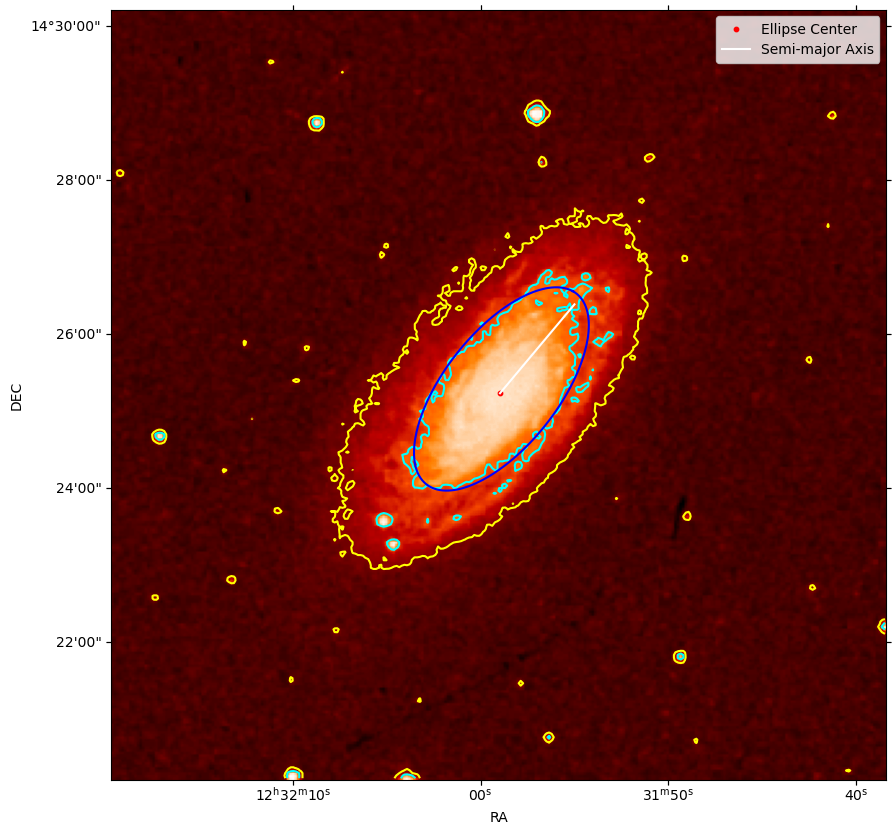

Effective radius: 47.16 pixels
Effective radius: 94.3179 acrsec


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from photutils.isophote import EllipseGeometry, Ellipse
from scipy.ndimage import gaussian_filter

def get_object_coordinates(object_name):
    result_table = Simbad.query_object(object_name)
    ra, dec = result_table["RA"][0], result_table["DEC"][0]
    return SkyCoord(f"{ra} {dec}", unit=(u.hourangle, u.deg))

def get_image_data(coords, survey='DSS', radius=5*u.arcmin):
    image_list = SkyView.get_images(position=coords, survey=survey, radius=radius)
    return image_list[0][0].data, WCS(image_list[0][0].header)

def setup_plot(data, wcs):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': wcs})
    ra, dec = ax.coords
    ra.set_major_formatter("hh:mm:ss")
    dec.set_major_formatter("dd:mm:ss")
    ax.set_xlabel("RA")
    ax.set_ylabel("DEC")
    return fig, ax

def plot_image_and_contours(ax, data):
    sqrt_data = np.sqrt(data + 1)
    ax.imshow(sqrt_data, cmap="gist_heat", origin="lower", aspect="auto")
    
    min_val, max_val = np.min(sqrt_data), np.max(sqrt_data)
    levels = np.linspace(min_val, max_val, 4)[1:-1]  # 2 intermediate levels
    contours = ax.contour(sqrt_data, levels, colors=['yellow', 'cyan'])
    return sqrt_data, contours

def fit_and_plot_ellipse(ax, data, contour_levels):
    center = np.array(data.shape) // 2
    geometry = EllipseGeometry(x0=center[1], y0=center[0], sma=20, eps=0.1, pa=45)
    ellipse = Ellipse(data, geometry)
    isolist = ellipse.fit_image()
    
    for iso in isolist:
        if contour_levels[0] < iso.intens < contour_levels[1]:
            x, y = iso.sampled_coordinates()
            ax.plot(x, y, color='blue')
            
            ax.scatter(center[1], center[0], color='red', s=10, label='Ellipse Center')
            
            angle = np.deg2rad(50)
            radius = iso.sma
            end_x = center[1] + radius * np.cos(angle)
            end_y = center[0] + radius * np.sin(angle)
            ax.plot([center[1], end_x-1.5], [center[0], end_y-1.5], color='white', label='Semi-major Axis')
            
            return radius
    return None

def calculate_holmberg_radius(data, center, sky_level):
    # Görüntüyü yumuşatma
    smoothed_data = gaussian_filter(data, sigma=2)
    
    # Merkez pikselinden başlayarak dışa doğru tarama
    y, x = np.ogrid[-center[0]:data.shape[0]-center[0], -center[1]:data.shape[1]-center[1]]
    distances = np.sqrt(x*x + y*y)
    
    holmberg_level = 0.265 * sky_level  # Holmberg seviyesi
    
    for r in range(1, min(data.shape) // 2):
        mask = (distances <= r) & (distances > r-1)
        ring_values = smoothed_data[mask]
        if np.median(ring_values) <= holmberg_level:
            return r
    
    return None

def plot_holmberg_radius(ax, center, radius):
    circle = plt.Circle(center, radius, color='green', fill=False, linestyle='--', label='Holmberg Radius')
    ax.add_artist(circle)

def main():
    # Get M88 coordinates
    m88_coords = get_object_coordinates("M88")
    
    # Get image data
    data, wcs = get_image_data(m88_coords)
    
    # Setup plot
    fig, ax = setup_plot(data, wcs)
    
    # Plot image and contours
    sqrt_data, contours = plot_image_and_contours(ax, data)
    
    # Fit and plot ellipse
    effective_radius = fit_and_plot_ellipse(ax, sqrt_data, contours.levels)
    
    # Calculate and plot Holmberg radius
    center = np.array(data.shape) // 2
    sky_level = np.median(data[0:50, 0:50])  # Gökyüzü seviyesini tahmin etmek için köşe bölgeyi kullan
    holmberg_radius = calculate_holmberg_radius(data, center, sky_level)
    
    if holmberg_radius:
        plot_holmberg_radius(ax, (center[1], center[0]), holmberg_radius)
        print(f"Holmberg radius: {holmberg_radius:.2f} pixels")
    else:
        print("Could not determine the Holmberg radius.")
    
    # Finalize plot
    ax.legend()
    plt.show()
    
    if effective_radius:
        print(f"Effective radius: {effective_radius:.2f} pixels")
        pix_scale = wcs.pixel_scale_matrix[1, 1] * 3600  # Piksel ölçeği yay saniyesi cinsinden
        radius_arcsec = effective_radius * pix_scale
        print(f"Effective radius: {radius_arcsec:.4f} acrsec")
    else:
        print("Could not determine the effective radius.")

main()

In [20]:
def estimate_sky_level(data):
    # Görüntünün köşelerindeki 50x50 piksel alanlardan medyan parlaklık değerini hesapla
    corners = [
        data[0:50, 0:50],  # Sol üst köşe
        data[-50:, 0:50],  # Sol alt köşe
        data[0:50, -50:],  # Sağ üst köşe
        data[-50:, -50:]   # Sağ alt köşe
    ]

    combined_corners = np.concatenate([corner.flatten() for corner in corners])
    
    # Medyan parlaklık değeri
    sky_level = np.median(combined_corners)

    # Köşeleri görselleştirme
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(data, cmap='gist_heat', origin='lower')

    for i, corner in enumerate(corners):
        y, x = divmod(i, 2)
        rect = plt.Rectangle((x * (data.shape[1] - 50), y * (data.shape[0] - 50)), 50, 50, fill=False, edgecolor='red', linestyle='--', linewidth=2)
        ax.add_patch(rect)

    plt.title(f"Estimated Sky Level: {sky_level:.2f}")
    plt.show()

    return sky_level


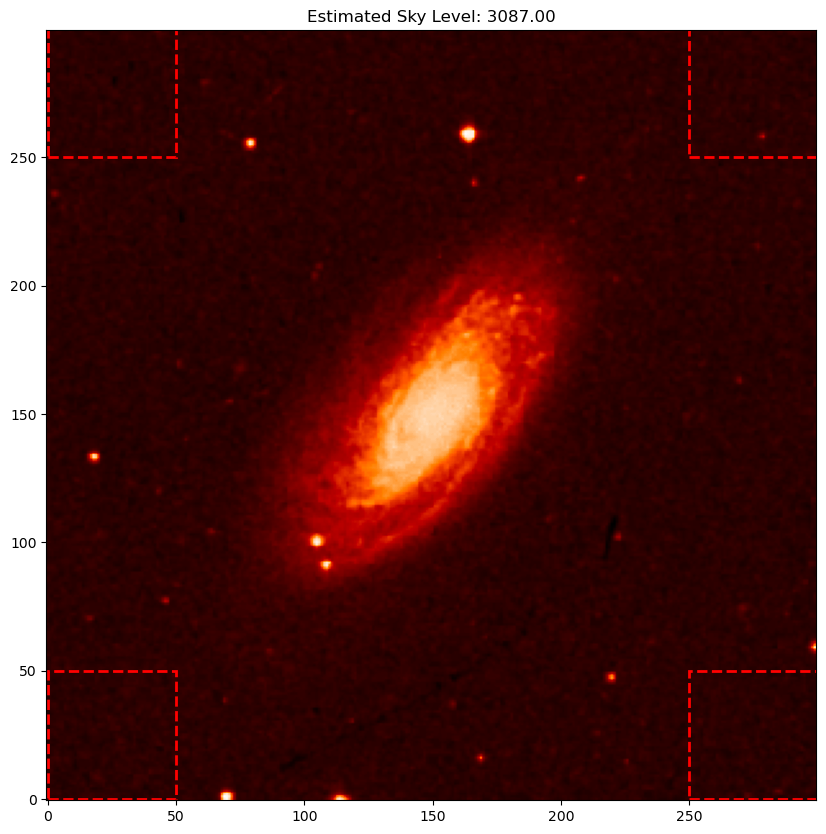

3087.0

In [21]:
# Get M88 coordinates
m88_coords = get_object_coordinates("M88")
# Get image data
data, wcs = get_image_data(m88_coords)
estimate_sky_level(data)